# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19


Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np
from torchvision.transforms.functional import normalize, resize, to_pil_image
from os.path import join

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.8.1+cpu


In [2]:
pip install torchcam

Note: you may need to restart the kernel to use updated packages.


# Preparing Training and Test Sets

In [3]:
class_names = ['Normal', 'Viral Pneumonia', 'COVID']
# root_dir = 'COVID-19 Radiography Database'
root_dir = r'C:\Users\SILVIA\Desktop\UIC\BIOE 494- Biomedical Computer Vision\Project\archive\COVID-19_Radiography_Dataset'
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30) ##qui vado a scegliere la dimensione del testset
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

FileExistsError: [WinError 183] Impossibile creare un file, se il file esiste già: 'C:\\Users\\SILVIA\\Desktop\\UIC\\BIOE 494- Biomedical Computer Vision\\Project\\archive\\COVID-19_Radiography_Dataset\\test'

# Creating Custom Dataset

In [4]:
class ChestXRayDataset(torch.utils.data.Dataset): #la classe chestxray è un sottoinsieme delle classi Dataset, predefinita in
                                                  # pythorch
    def __init__(self, image_dirs, transform): 
        #transform sarà utilizzata per la data augmentation e per alcune altre trasformazioni, come il resize delle immagini
        # questa classe è composta da funzioni che: prendono le immagini e le salvano in un'apposita variabile
        
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['Normal', 'Viral Pneumonia', 'COVID']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
        # salvo, per tutte e tre le classi, le immagini corrispondenti nel dataset. 
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    #semplicemente mi dice quante immagini ci sono per ogni classe
    
    def __getitem__(self, index): #serve a selezionare la i-esima immagine, dove i è l'indice che viene randomicamente passato 
        # alla funzione di volta in volta. 
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name]) #questo serve solo ad evitare out of bounds dell'indice! 
        image_name = self.images[class_name][index] #estraggo il nome 
        image_path = os.path.join(self.image_dirs[class_name], image_name) #joino la classe con il nome dell'immagine ed ho il 
        #path
        image = Image.open(image_path).convert('RGB') #Image è una classe della libreria PIL, che serve ad aprire le immagini 
        # presenti nel path che gli viene passato. convertiamo in RGB perché sono principalmente immagini BW, ma il nostro
        # resnet18 è pretrainato su immagini RGB! problema: dovremo convertire le immagini in tensori, perché pythorch lavora
        #con i tensori. 
        return self.transform(image), self.class_names.index(class_name)
    #ritorniamo l'immagine trasformata. ora bisogna definire la trasformazione

# Image Transformations

In [5]:
train_transform = torchvision.transforms.Compose([ #creiamo la lista di trasformazioni che ci interessa applicare alle immagini
    torchvision.transforms.Resize(size=(224, 224)), #resnet18 lavora con questi valori 
    torchvision.transforms.RandomHorizontalFlip(), #un po' di data augmentation 
    torchvision.transforms.ToTensor(), #importante perché pythorch lavora coi tensori
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #valori di riferimento per resnet18
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
#non facciamo data augmentation nel testset! la differenza è solo questa. 

# Prepare DataLoader

In [6]:
train_dirs = {
    'Normal': f'{root_dir}/Normal',
    'Viral Pneumonia': f'{root_dir}/Viral Pneumonia',
    'COVID': f'{root_dir}/COVID'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)
print (train_dataset)

Found 10042 Normal examples
Found 1195 Viral Pneumonia examples
Found 3466 COVID examples


In [7]:
test_dirs = {
    'Normal': f'{root_dir}/test/Normal',
    'Viral Pneumonia': f'{root_dir}/test/Viral Pneumonia',
    'COVID': f'{root_dir}/test/COVID'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 Normal examples
Found 30 Viral Pneumonia examples
Found 30 COVID examples


In [8]:
batch_size = 6 #how many samples per batch to load
# il dataloader è una classe che sfrutta la parallelizzazione del computer per caricare più velocemente le immagini
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test)) #sono 15, 15*batch_size=90, come le test images! 
#i dataloader sono tipi di oggetto che contengono il sample (immagine) e la sua etichetta. 

Number of training batches 2451
Number of test batches 15


In [28]:
print(dl_train)

# Data Visualization

In [9]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0)) #per plottare le immagini, che ora sono state convertite in tensori,
        # torniamo al formato standard e poi andiamo a moltiplicare per la std e sommiamo la media. a quel punto clippiamo
        # e l'immagine è correttamente visualizzabile, clippiamo significa che i valori superiori ad 1 diventano 1 e sotto 0
        #diventano 0 
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

In [1]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)
#chiaramente qui tutti i risultati sono in verde perché non ho fatto alcuna predizione, ho solo usato l'etichetta dell'immagine
#che ho già a disposizione

NameError: name 'dl_train' is not defined

In [1]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

NameError: name 'dl_test' is not defined

# Creating the Model

In [10]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)
# il resnet18 pretrainato ha un dataset composto da 1000 classi, le out features, mentre noi ne abbiamo solo 3. 
# bisogna cambiare questo parametro cambiando l'ultimo fully connected layer 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# l'ultimo fully connected layer (fc) è di tipo linear. allora lo sostituisco con un altro nn.linear, 
# cambiando i parametri di output

resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5) #ottimizziamo i parametri (pesi) del cnn usando l'optimizer di Adam

In [15]:
def show_preds():
    resnet18.eval() #settiamo il modello in modalità valutazione (?) 
    images, labels = next(iter(dl_test)) #prendiamo alcune immagini a caso, estraendo anche l'etichetta
    outputs = resnet18(images) #prediciamo l'etichetta
    #print(outputs)
    _, preds = torch.max(outputs, 1) #prendiamo il massimo perché ci darà un array di 3 elementi che rappresentano la probabilità
    # che quell'immagine appartenga a quella classe. non ci interessa la prima uscita della funzione, per questo c'è il "_".
    # la dimensione 0 è il campione, la dimensione 1 è il valore probabilistico di quella specifica etichetta.
    show_images(images, labels, preds)

In [23]:
show_preds()

NameError: name 'show_preds' is not defined

# Training the Model

In [67]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20) #cornice
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # entriamo in modalità training (?)

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad() #resettiamo l'optimizer, che prima era stato utilizzato per stimare i parametri, ora sarà 
            #aggiornato ad ogni epoca
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels) #cross entropy definita precedentemente
            loss.backward() #si attiva la backpropagation (??)
            optimizer.step() #update dei parametri dell'ottimizzatore una volta effettuata la backpropagation
            train_loss += loss.item() #andiamo ad aumentare il valore della train_loss del valore calcolato tramite l'ottimizzazione
            # loss è un tensore, quindi si deve estrarre il valore che contiene, che è in loss.item()
            
            
            if train_step % 20 == 0: #ogni 20 passi valutiamo il nostro modello! perciò si passa alla modalità valutazione (?)
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # modalità valutazione (?)

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    #qui è identico al trainset
                    
                    _, preds = torch.max(outputs, 1) #stesso discorso di prima, si prende l'etichetta piu probabile
                    accuracy += sum((preds == labels).numpy()) #alla fine andremo a dividere per il numero totale di campioni

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                #show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

In [68]:
%%time

train(epochs=1)

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.3056, Accuracy: 0.1556
Evaluating at step 20
Validation Loss: 1.3256, Accuracy: 0.2667
Evaluating at step 40
Validation Loss: 1.2893, Accuracy: 0.2889
Evaluating at step 60
Validation Loss: 1.2542, Accuracy: 0.3111
Evaluating at step 80
Validation Loss: 1.1462, Accuracy: 0.3333
Evaluating at step 100
Validation Loss: 1.1533, Accuracy: 0.4000
Evaluating at step 120
Validation Loss: 1.1666, Accuracy: 0.3889
Evaluating at step 140
Validation Loss: 1.1734, Accuracy: 0.3778
Evaluating at step 160
Validation Loss: 1.1150, Accuracy: 0.3778
Evaluating at step 180
Validation Loss: 1.1457, Accuracy: 0.3111
Evaluating at step 200
Validation Loss: 1.1656, Accuracy: 0.3222
Evaluating at step 220
Validation Loss: 1.2290, Accuracy: 0.2556
Evaluating at step 240
Validation Loss: 1.1872, Accuracy: 0.3333
Evaluating at step 260
Validation Loss: 1.1949, Accuracy: 0.3444
Evaluating at step 280
Validation Loss: 1.1673, Accuracy:

# Final Results

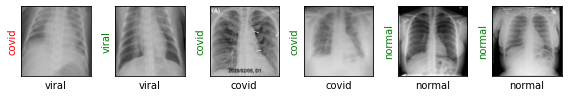

In [19]:
show_preds()

# Saving the Model

In [14]:
torch.save(resnet18.state_dict(), 'covid_classifier.pt')

In [15]:
model=torch.load ('covid_classifier.pt')

# Inference on a Single Image

In [16]:
# Load the model and set in eval
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)

resnet18.load_state_dict(torch.load('covid_classifier.pt'))
resnet18.eval()
#model=resnet18()


def predict_image_class(image_path):
    image = Image.open(image_path).convert('RGB')
    image = test_transform(image)
    # Please note that the transform is defined already in a previous code cell
    image = image.unsqueeze(0)
    output = resnet18(image)[0]
    probabilities = torch.nn.Softmax(dim=0)(output)
    probabilities = probabilities.cpu().detach().numpy()
    predicted_class_index = np.argmax(probabilities)
    predicted_class_name = class_names[predicted_class_index]
    return probabilities, predicted_class_index, predicted_class_name

## CAM 

In [17]:
from torchcam.utils import overlay_mask
from torchcam.cams import SmoothGradCAMpp

In [18]:
# Define your model
model=resnet18.eval()
model.fc=torch.nn.Linear(in_features=512, out_features=3)

# Set your CAM extractor
cam_extractor = SmoothGradCAMpp(model)

### Covid CAM 

In [ ]:
dirpath1= r'C:\Users\SILVIA\Desktop\UIC\BIOE 494- Biomedical Computer Vision\Project\archive\COVID-19_Radiography_Dataset\test\COVID'

for filename in os.listdir(dirpath1)[0:3]:         
    target_path= join(dirpath1,filename)
    image = Image.open(target_path).convert('RGB')

    image1 = test_transform(image)

    cam_extractor = SmoothGradCAMpp(model)
    # Get your input
    img = image1
  
    # Preprocess it for your chosen model
    input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # Preprocess your data and feed it to the model
    out = model(input_tensor.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
    # Resize the CAM and overlay it
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map, mode='F'), alpha=0.5)


    # Visualize the raw CAM
    fig,ax = plt.subplots(1, 2)
    ax[0].imshow(image)
    ax[0].axis('off')

    ax[1].imshow(result)
    ax[1].axis('off')
    

### Normal CAM 

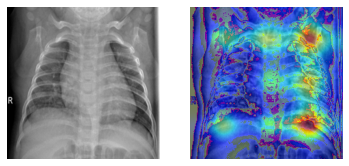

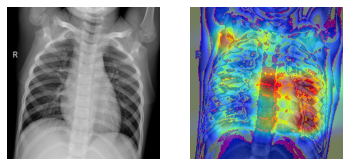

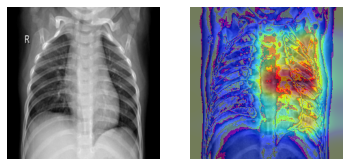

In [28]:
dirpath2=r'C:\Users\SILVIA\Desktop\UIC\BIOE 494- Biomedical Computer Vision\Project\archive\COVID-19_Radiography_Dataset\test\Normal'

for filename in os.listdir(dirpath2)[0:3]:  
    target_path= join(dirpath2,filename)
    image = Image.open(target_path).convert('RGB')

    image1 = test_transform(image)

    cam_extractor = SmoothGradCAMpp(model)
    # Get your input
    img = image1
   
    # Preprocess it for your chosen model
    input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # Preprocess your data and feed it to the model
    out = model(input_tensor.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
    # Resize the CAM and overlay it
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map, mode='F'), alpha=0.5)


    # Visualize the raw CAM
    fig,ax = plt.subplots(1, 2)
    ax[0].imshow(image)
    ax[0].axis('off')

    ax[1].imshow(result)
    ax[1].axis('off')
    


### Viral CAM 

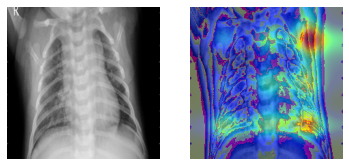

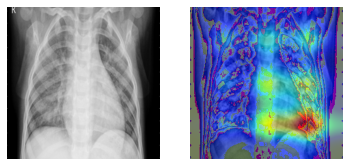

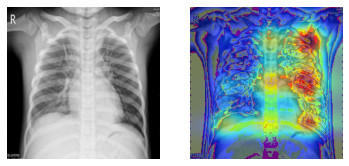

In [29]:
dirpath3=r'C:\Users\SILVIA\Desktop\UIC\BIOE 494- Biomedical Computer Vision\Project\archive\COVID-19_Radiography_Dataset\test\Viral Pneumonia'
for filename in os.listdir(dirpath3)[0:3]:         
    target_path= join(dirpath3,filename)
    image = Image.open(target_path).convert('RGB')

    image1 = test_transform(image)

    cam_extractor = SmoothGradCAMpp(model)
    # Get your input
    img = image1
   
    # Preprocess it for your chosen model
    input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # Preprocess your data and feed it to the model
    out = model(input_tensor.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
    # Resize the CAM and overlay it
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map, mode='F'), alpha=0.5)


    # Visualize the raw CAM
    fig,ax = plt.subplots(1, 2)
    ax[0].imshow(image)
    ax[0].axis('off')

    ax[1].imshow(result)
    ax[1].axis('off')


In [56]:
class_names = ['Normal', 'Viral Pneumonia', 'COVID']
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID']

for i in range(3) :

#metti path a COVID-19_Radiography_Dataset
    root_dir = '/Users/SILVIA/Desktop/UIC/BIOE 494- Biomedical Computer Vision/Project/archive/COVID-19_Radiography_Dataset'
    if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
        os.mkdir(os.path.join(root_dir, 'train{}'.format(i)))

    for z, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[z]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'train{}'.format(i), c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
    
        for image in images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'train{}'.format(i), c, image)
            shutil.copyfile(source_path, target_path)
            
#metti path to COVID-19_Radiography_Dataset e aggiungi alla fine'/train{}'.format(i)'    
    root_dir_test = '/Users/SILVIA/Desktop/UIC/BIOE 494- Biomedical Computer Vision/Project/archive/COVID-19_Radiography_Dataset/train{}'.format(i)
    os.mkdir(os.path.join(root_dir_test, 'test{}'.format(i)))

    for z, d in enumerate(source_dirs):
         os.rename(os.path.join(root_dir_test, d), os.path.join(root_dir_test, class_names[z]))

    for c in class_names:
         os.mkdir(os.path.join(root_dir_test, 'test{}'.format(i), c))
    
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30) ##qui vado a scegliere la dimensione del testset
        for image in selected_images:
            source_path = os.path.join(root_dir_test, c, image)
            target_path = os.path.join(root_dir_test, 'test{}'.format(i), c, image)
            shutil.move(source_path, target_path)

FileExistsError: [WinError 183] Impossibile creare un file, se il file esiste già: '/Users/SILVIA/Desktop/UIC/BIOE 494- Biomedical Computer Vision/Project/archive/COVID-19_Radiography_Dataset\\train0'

In [88]:
def train(epochs):
    print('Starting training..')
    class_names = ['Normal', 'Viral Pneumonia', 'COVID']
    source_dirs = ['Normal', 'Viral Pneumonia', 'COVID']
    root_dir = '/Users/SILVIA/Desktop/UIC/BIOE 494- Biomedical Computer Vision/Project/archive/COVID-19_Radiography_Dataset'
    for e in range(0, epochs):
        print('='*20) #cornice
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)
        
        train_loss = 0.
        val_loss = 0.
        folds_switch= np.array([1,2,3])

        resnet18.train() # entriamo in modalità training (?)
        for j in range(3) :
            
            test_fold = str(j);
            train_fold = np.argwhere(folds_switch!=j)
            root_dir = '/Users/SILVIA/Desktop/UIC/BIOE 494- Biomedical Computer Vision/Project/archive/COVID-19_Radiography_Dataset/train{}.format(j)'
            train1_normal = os.path.join(root_dir, 'train{}'.format(train_fold), class_names[0] )
            train1_viral = os.path.join(root_dir, 'train{}'.format(train_fold), class_names[1] )
            train1_covid = os.path.join(root_dir, 'train{}'.format(train_fold), class_names[2] )
            train2_normal = os.path.join(root_dir, 'train{}'.format(train_fold), class_names[0] )
            train2_viral = os.path.join(root_dir, 'train{}'.format(train_fold), class_names[1] )
            train2_covid = os.path.join(root_dir, 'train{}'.format(train_fold), class_names[2] )
            test_normal = os.path.join(root_dir, 'test{}'.format(test_fold), class_names[0])
            test_viral = os.path.join(root_dir, 'test{}'.format(test_fold), class_names[1])
            test_covid = os.path.join(root_dir, 'test{}'.format(test_fold), class_names[2])
            
            train_dataset1 = ChestXRayDataset(train1_normal, train1_viral, train1_covid,train2_normal, train2_viral, train2_covid, train_transform)
            test_dataset1 = ChestXRayDataset(test_normal, test_viral, test_covid, test_transform)
            dl_train1 = torch.utils.data.DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
            dl_test1 = torch.utils.data.DataLoader(test_dataset1, batch_size=batch_size, shuffle=True)

            for train_step, (images, labels) in enumerate(dl_train1):

                optimizer.zero_grad() #resettiamo l'optimizer, che prima era stato utilizzato per stimare i parametri, ora sarà 
                #aggiornato ad ogni epoca
                outputs = resnet18(images)
                loss = loss_fn(outputs, labels) #cross entropy definita precedentemente
                loss.backward() #si attiva la backpropagation (??)
                optimizer.step() #update dei parametri dell'ottimizzatore una volta effettuata la backpropagation
                train_loss += loss.item() #andiamo ad aumentare il valore della train_loss del valore calcolato tramite l'ottimizzazione
                # loss è un tensore, quindi si deve estrarre il valore che contiene, che è in loss.item()


                if train_step % 20 == 0: #ogni 20 passi valutiamo il nostro modello! perciò si passa alla modalità valutazione (?)
                    print('Evaluating at step', train_step)

                    accuracy = 0

                    resnet18.eval() # modalità valutazione (?)

                    for val_step, (images, labels) in enumerate(dl_test1):
                        outputs = resnet18(images)
                        loss = loss_fn(outputs, labels)
                        val_loss += loss.item()

                        #qui è identico al trainset

                        _, preds = torch.max(outputs, 1) #stesso discorso di prima, si prende l'etichetta piu probabile
                        accuracy += sum((preds == labels).numpy()) #alla fine andremo a dividere per il numero totale di campioni

                    val_loss /= (val_step + 1)
                    accuracy = accuracy/len(test_dataset)
                    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                    

                    resnet18.train()

                    if accuracy >= 0.95:
                        print('Performance condition satisfied, stopping..')
                        return

            train_loss /= (train_step + 1)

            print(f'Training Loss: {train_loss:.4f}')
        print('Training complete..')

In [89]:
%%time

train(epochs=1)

Starting training..
Starting epoch 1/1


TypeError: 'set' object is not subscriptable